# FinRL 全流程工作流示例

本 Notebook 演示从数据获取到策略训练/选股、回测与交易执行（Alpaca 纸面交易）的完整流程。

步骤概览：
- 获取 S&P500 成分并设定研究区间
- 使用 `data_fetcher` 获取真实基本面（开启 `align_quarter_dates=True`，并包含前瞻 `y_return` 标签）
- 使用 `ml_strategy` 的行业滚动选股（若无行业列则回退至基础 ML 选股）并导出权重 CSV
- 使用 `backtest_engine`（bt 库）对权重进行回测并输出指标
- 使用 `trade_executor` 展示 Alpaca 账户状态、生成 dry-run 计划，并可选执行纸面交易

运行前准备：
- 安装依赖：在项目根目录执行 `pip install -r requirements.txt`
- 如需使用 FMP 或 Alpaca，请配置 `.env`（参见 `README.md` / `.env.example`）
- 首次运行会在 `data/cache/` 生成缓存文件，避免重复拉取数据



In [1]:
!pip install -r ../requirements.txt

  Using cached flake8-7.3.0-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached mccabe-0.7.0-py2.py3-none-any.whl.metadata (5.0 kB)
  Using cached pycodestyle-2.14.0-py2.py3-none-any.whl.metadata (4.5 kB)
  Using cached pyflakes-3.4.0-py2.py3-none-any.whl.metadata (3.5 kB)
   ---------------------------------------- 0.0/122.2 kB ? eta -:--:--
   ---------------------------------------- 122.2/122.2 kB ? eta 0:00:00
Using cached flake8-7.3.0-py2.py3-none-any.whl (57 kB)
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------- ----------------------------- 2.7/9.8 MB 82.9 MB/s eta 0:00:01
   ----------------------- ---------------- 5.8/9.8 MB 73.6 MB/s eta 0:00:01
   ------------------------------------- -- 9.1/9.8 MB 72.3 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 62.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/3.6 MB ? eta -:--:--
   -------------------------------------- - 3.4/3.6 MB 106.6 MB/s eta 0:00:01
 

In [1]:
# 环境与路径设置
import os, sys, logging
from datetime import datetime, timedelta
from pathlib import Path

# 在 Notebook 中使用工作目录推断项目根目录（本文件位于 examples/ 下）
nb_dir = Path().resolve()
project_root = str(nb_dir.parent)
print(f"project_root: {project_root}")
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    sys.path.insert(0, os.path.join(project_root, 'src'))

logging.basicConfig(level=logging.INFO)



project_root: D:\Projects\quant\FinRL-Trading


In [2]:
# 数据源初始化与成分/区间设定
from src.data.data_fetcher import get_data_manager, fetch_sp500_tickers

preferred_source="fmp"
# 选择数据源（自动优先 FMP / WRDS，不可用时回退 Yahoo）
manager = get_data_manager(cache_dir=str(Path(project_root) / 'data' / 'cache'), preferred_source=preferred_source)
print(manager.get_source_info())

# 获取S&P500成分（若失败会使用回退列表），并选择前若干只提高演示速度
tickers = fetch_sp500_tickers(output_path=str(Path(project_root) / 'data' / 'sp500_tickers.txt'), preferred_source=preferred_source)
print(f"Total tickers: {len(tickers)} (show first 15)", tickers[:15])

# 研究时间区间（保证覆盖数年，便于滚动）
start_date = '2019-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')
print(start_date, '->', end_date)



project_root: D:\Projects\quant\FinRL-Trading
project_root: D:\Projects\quant\FinRL-Trading


INFO:src.data.data_store:Initialized database at data\finrl_trading.db
INFO:src.data.data_fetcher:Using preferred data source: FMP
INFO:src.data.data_fetcher:Using preferred data source: FMP
INFO:src.data.data_fetcher:Loading S&P 500 components from database for 2025-10-12
INFO:src.data.data_fetcher:Saved 503 tickers to D:\Projects\quant\FinRL-Trading\data\sp500_tickers.txt


{'current_source': 'FMP', 'available_sources': ['FMP'], 'cache_dir': 'D:\\Projects\\quant\\FinRL-Trading\\data\\cache'}
Total tickers: 503 (show first 15) ['DXCM', 'NSC', 'IDXX', 'VST', 'MCK', 'CPB', 'ADM', 'BX', 'NEM', 'AXON', 'NVDA', 'WST', 'AMP', 'FOXA', 'JKHY']
2019-01-01 -> 2025-10-12


In [ ]:
# 获取基本面（align_quarter_dates=True），并校验 y_return
import pandas as pd
from src.data.data_fetcher import fetch_fundamental_data

# 为了演示速度，可以限制股票数量，例如前 80 只；实际可扩大
# tickers_small = tickers[:80]

fundamentals = fetch_fundamental_data(
    tickers,
    start_date,
    end_date,
    # output_path=str(Path(project_root) / 'data' / 'fundamentals.csv'),
    align_quarter_dates=True,    # 将交易时间从财报发布日向后推移约2月，以对齐不同公司交易日
    preferred_source=preferred_source
)
print(f"fundamentals shape: {fundamentals.shape}")

# 基本校验：应包含 y_return（由 fetcher 计算的下一季度收益率）
if 'y_return' not in fundamentals.columns:
    raise ValueError("fundamentals 缺少 y_return，请检查 data_fetcher 实现")

# 推荐仅保留有效标签样本
aaa = fundamentals.copy()
# aaa = aaa[aaa['y_return'].notna()].reset_index(drop=True)
print(f"after dropna(y_return): {aaa.shape}")

# 保存一份清洁数据
clean_path = Path(project_root) / 'data' / 'fundamentals_clean.csv'
aaa.to_csv(clean_path, index=False)
print(f"Saved cleaned fundamentals to {clean_path}")



after dropna(y_return): (13236, 21)
Saved cleaned fundamentals to D:\Projects\quant\FinRL-Trading\data\fundamentals_clean.csv


In [8]:
# 行业滚动选股并保存权重 CSV
from src.strategies.base_strategy import StrategyConfig
from src.strategies.ml_strategy import MLStockSelectionStrategy, SectorNeutralMLStrategy
from src.data.data_fetcher import fetch_price_data

# 读取清洁基本面数据（若外部提供了 sector/gsector 列，将启用行业中性版本）
fundamentals_clean = pd.read_csv(Path(project_root) / 'data' / 'fundamentals_clean.csv')
# prices_df = fetch_price_data(tickers, start_date, end_date)

config = StrategyConfig(
    name="ML Stock Selection",
    description="Machine learning based stock selection"
)
base_strategy = MLStockSelectionStrategy(config)
sector_config = StrategyConfig(
    name="Sector Neutral ML",
    description="Sector-neutral ML strategy"
)
sector_strategy = SectorNeutralMLStrategy(sector_config)

# data_dict = { 'fundamentals': fundamentals_clean, 'prices': prices_df }
data_dict = { 'fundamentals': fundamentals_clean}

# 采用滚动模式：每个季度独立训练/验证并预测
test_quarters = 4
top_quantile = 0.9

# 如果存在行业列，使用行业滚动选股，否则回退基础版本
# sector_col_exists = ('sector' in fundamentals_clean.columns) or ('gsector' in fundamentals_clean.columns)
sector_col_exists = False
if sector_col_exists:
    res = sector_strategy.generate_weights(
        data_dict,
        test_quarters=test_quarters,
        top_quantile=top_quantile,
        prediction_mode='rolling'
    )
else:
    res = base_strategy.generate_weights(
        data_dict,
        test_quarters=test_quarters,
        top_quantile=top_quantile,
        prediction_mode='rolling'
    )
    # res = base_strategy.generate_weights(
    #     data=data_dict,
    #     prediction_mode='rolling',
    #     test_quarters=test_quarters,
    #     top_quantile=top_quantile,
    #     weight_method='equal',
    #     confirm_mode='today',
    #     execution_date='2025-10-12'  # 下单日期（或希望确认的日期）
    # )

weights = res.weights.copy()
print(f"weights rows: {len(weights)}")

# 保存权重
out_dir = Path(project_root) / 'data'
out_dir.mkdir(parents=True, exist_ok=True)
if sector_col_exists:
    out_path = out_dir / 'ml_weights_sector.csv'
else:
    out_path = out_dir / 'ml_weights.csv'
weights.to_csv(out_path, index=False)
print(f"Saved weights to {out_path}")



INFO:src.strategies.base_strategy.MLStockSelectionStrategy:Generating ML-based weights


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 7652, number of used features: 15
[LightGBM] [Info] Start training from score 0.024414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 8097, number of used features: 15
[LightGBM] [Info] Start training from score 0.022332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 8101, number of used features: 15
[LightGBM] [Info] Start traini

INFO:src.strategies.base_strategy.MLStockSelectionStrategy:生成 ML 滚动权重，共 309 条、覆盖 7 个日期


weights rows: 309


PermissionError: [Errno 13] Permission denied: 'D:\\Projects\\quant\\FinRL-Trading\\data\\ml_weights.csv'

In [10]:
# 使用 bt 库回测权重，并输出指标
import pandas as pd
from src.backtest.backtest_engine import BacktestConfig, BacktestEngine
from src.data.data_fetcher import fetch_price_data

# 读取权重
weights_path = out_path  # 来自上一单元
weights_raw = pd.read_csv(weights_path)
assert {'date','gvkey','weight'}.issubset(weights_raw.columns), '权重文件应包含 date/gvkey/weight'
weights_raw['date'] = pd.to_datetime(weights_raw['date'])
weights_raw['gvkey'] = weights_raw['gvkey'].astype(str)
weights_raw = weights_raw.sort_values(['date','gvkey'])

# 生成权重矩阵（行：日期，列：ticker）
weight_signals = (
    weights_raw
    .pivot_table(index='date', columns='gvkey', values='weight', aggfunc='sum')
    .fillna(0.0)
    .sort_index()
)

# 过滤全 0 的行
weight_signals = weight_signals.loc[(weight_signals.sum(axis=1) > 0.0)]
assert len(weight_signals) > 0, '权重矩阵为空，无法回测'

# 回测时间区间：覆盖权重范围并向后延申 90 天
t_start = weight_signals.index.min().strftime('%Y-%m-%d')
t_end = (weight_signals.index.max() + pd.Timedelta(days=90)).strftime('%Y-%m-%d')

cfg = BacktestConfig(
    start_date=t_start,
    end_date=t_end,
    rebalance_freq='Q',
    initial_capital=1_000_000.0
)

# 拉取价格数据
tickers_bt = weight_signals.columns.tolist()
prices_long = fetch_price_data(tickers_bt, cfg.start_date, cfg.end_date)

# 运行回测
engine = BacktestEngine(cfg)
price_data_bt = engine._prepare_price_data_for_bt(prices_long)

# 对齐权重日期到可交易日并归一化
from pandas import DataFrame
common_cols = [c for c in weight_signals.columns if c in price_data_bt.columns]
weight_signals = weight_signals[common_cols]
trading_index = price_data_bt.index
pos = trading_index.get_indexer(weight_signals.index, method='bfill')
mask = pos != -1
weight_signals = weight_signals.iloc[mask]
weight_signals.index = trading_index[pos[mask]]

# 清洗每日无价格的股票并归一
aligned = []
for dt, row in weight_signals.iterrows():
    prices_today = price_data_bt.loc[dt, row.index]
    valid_cols = prices_today.dropna().index.tolist()
    if len(valid_cols) == 0:
        continue
    row_valid = row[valid_cols]
    s = row_valid.sum()
    if s <= 0:
        continue
    aligned.append((dt, (row_valid / s)))

if aligned:
    weight_signals = DataFrame({dt: vec for dt, vec in aligned}).T.sort_index()
else:
    raise ValueError('对齐后无有效权重行')

# 再次行归一
weight_signals = weight_signals.div(weight_signals.sum(axis=1), axis=0).fillna(0)

result = engine.run_backtest('ML Weights Strategy', prices_long, weight_signals)
print(f"组合年化收益: {result.annualized_return:.2%}")
for bm, ann in (result.benchmark_annualized or {}).items():
    print(f"基准 {bm} 年化收益: {ann:.2%}")

metrics_df = result.to_metrics_dataframe()
metrics_df


INFO:src.data.data_fetcher:Using preferred data source: FMP
INFO:src.data.data_fetcher:Found 59517 existing price records in database
INFO:src.data.data_fetcher:Ticker GEV: Need to fetch price data
INFO:src.data.data_fetcher:Fetching price data for 1 tickers from FMP
INFO:src.data.data_fetcher:Returning 59517 total price records
INFO:src.data.data_fetcher:Retrieved 59517 price records from database
INFO:src.data.data_fetcher:Selected data source: FMP
INFO:src.backtest.backtest_engine.BacktestEngine:Running backtest for ML Weights Strategy using bt library
INFO:src.backtest.backtest_engine.BacktestEngine:Price data prepared for bt: shape (405, 147)
100%|██████████| 1/1 [00:02<00:00,  2.18s/it]
INFO:src.backtest.backtest_engine.BacktestEngine:Backtest period: 2024-02-29 -> 2025-10-10
INFO:src.backtest.backtest_engine.BacktestEngine:First value: 1000000.00, Last value: 1255531.69
INFO:src.data.data_fetcher:Found 405 existing price records in database
100%|██████████| 1/1 [00:00<00:00, 26.

组合年化收益: 15.16%
基准 SPY 年化收益: 17.65%
基准 QQQ 年化收益: 19.59%


,annual_return,annual_volatility,annualized_return,kurtosis,max_drawdown,monthly_return,monthly_sharpe,monthly_sortino,monthly_volatility,sharpe_ratio,skewness,sortino_ratio,total_return
ML Weights Strategy,0.151556,0.194610,0.151556,8.565262,-0.164922,0.012449,0.270577,0.443366,0.046010,0.778765,0.546370,1.144727,0.255532
SPY,0.176461,0.172845,0.176461,23.900550,-0.187539,0.013707,0.414617,0.774320,0.033058,1.020925,1.218271,1.285945,0.299610
QQQ,0.195868,0.218240,0.195868,15.236753,-0.227629,0.015339,0.369382,0.613794,0.041526,0.897489,0.885614,1.163512,0.334355


In [ ]:
print(weights_raw['gvkey'].tolist())

In [ ]:
# 展示 Alpaca 账户状态、生成 dry-run，并可选 paper trading 执行
import os
from src.trading.trade_executor import create_trade_executor_from_env
import pandas as pd

# 仅在配置好 Alpaca API 后执行。否则会抛错并提示。
try:
    executor = create_trade_executor_from_env()
    print("Trade executor initialized. Accounts:", executor.alpaca.get_available_accounts())

    # 使用上一单元生成的权重，取最后一个交易日的组合
    df = pd.read_csv(weights_path)
    df['date'] = pd.to_datetime(df['date']).dt.date
    latest_date = df['date'].max()
    df_latest = df[df['date'] == latest_date].copy()

    # 归一化并转换为目标权重
    df_latest = df_latest.groupby('gvkey', as_index=False)['weight'].sum()
    df_latest = df_latest[df_latest['weight'] > 0]
    s = df_latest['weight'].sum()
    if s <= 0:
        raise ValueError('最新调仓日权重和为0')
    df_latest['weight'] = df_latest['weight'] / s
    target_weights = {row['gvkey']: float(row['weight']) for _, row in df_latest.iterrows()}

    # 生成 dry-run 计划（不提交）
    plan = executor.alpaca.execute_portfolio_rebalance(
        target_weights,
        account_name='default',
        dry_run=True
    )
    print('Dry-run plan generated:')
    print('Market open:', plan.get('market_open'))
    print('Used TIF:', plan.get('used_time_in_force'))
    print('Planned sells:', len(plan.get('orders_plan', {}).get('sell', [])))
    print('Planned buys :', len(plan.get('orders_plan', {}).get('buy',  [])))


except Exception as e:
    print('Alpaca 初始化或执行失败:', e)
    print('如需启用该单元，请配置 .env 并参考 README 中的 Alpaca 设置说明。')

In [ ]:
# 根据市场状态选择是否提交（paper trading）
use_opg = os.getenv('USE_OPG', 'false').lower() == 'true'
if plan.get('market_open'):
    submit = executor.alpaca.execute_portfolio_rebalance(
        target_weights,
        account_name='default'
    )
    print('Submitted during market hours. Orders placed:', submit.get('orders_placed', 0))
else:
    if use_opg:
        submit = executor.alpaca.execute_portfolio_rebalance(
            target_weights,
            account_name='default',
            market_closed_action='opg'
        )
        print('Submitted as OPG. Orders placed:', submit.get('orders_placed', 0))
    else:
        print('Market is closed. Skipping submission. Set USE_OPG=true to submit OPG at open.')

project_root: D:\Projects\FinRL-Trading
project_root: D:\Projects\FinRL-Trading


INFO:src.data.data_fetcher:Cached price data for SPY to D:\Projects\FinRL-Trading\data\cache\prices_SPY_2025-08-24_2025-09-29.csv
INFO:src.data.data_fetcher:Cached price data for QQQ to D:\Projects\FinRL-Trading\data\cache\prices_QQQ_2025-08-24_2025-09-29.csv
INFO:src.data.data_fetcher:Saved price data to data\prices.csv



Performance Metrics (Aligned):
               Metric  Portfolio        SPY        QQQ
           Start Date 2025-08-26 2025-08-26 2025-08-26
             End Date 2025-09-26 2025-09-26 2025-09-26
     Total Return (%)      0.04%      2.87%      4.20%
    Annual Return (%)      0.57%     48.53%     77.88%
Annual Volatility (%)     12.34%      6.69%      8.50%
         Sharpe Ratio      -0.12       6.96       8.92
     Max Drawdown (%)     -2.04%     -0.85%     -1.21%


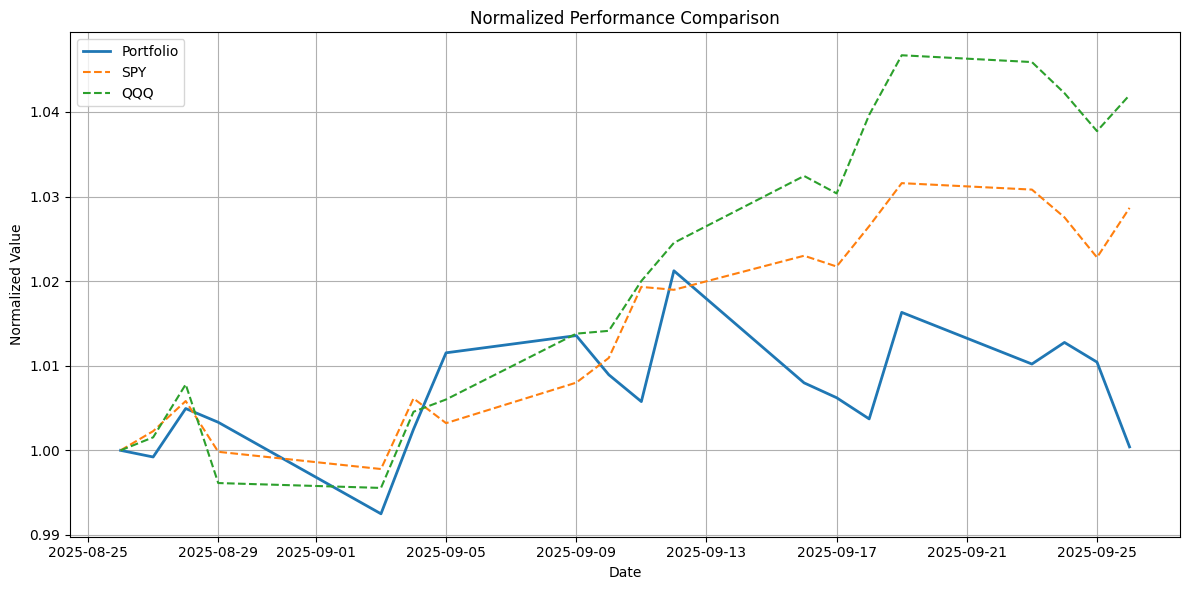

In [7]:
# 读取 Alpaca 账户历史并对比基准（SPY/QQQ）
import logging
from datetime import datetime, timedelta, timezone
from src.trading.performance_analyzer import (
    create_alpaca_account_from_env, AlpacaManager,
    get_first_order_date, get_portfolio_history,
    get_benchmark_data, display_metrics_table, plot_performance
)

try:
    logging.basicConfig(level=logging.INFO)
    # 创建 AlpacaManager
    account = create_alpaca_account_from_env()
    manager = AlpacaManager([account])

    # 时间区间：从第一笔订单到当前（或你也可自定义窗口）
    end_date = datetime.now(timezone.utc)
    first_order_date = get_first_order_date(manager)
    if first_order_date is None:
        raise RuntimeError('无法确定账户首笔订单日期，请确认账户有交易历史或检查API权限')

    # 保证获取到 end_date 当天数据（FMP端需要 +1 日），并给 start_date-1 天用于边界
    start_date = first_order_date - timedelta(days=1)
    start_date_str = start_date.date().isoformat()
    fmp_end_date = end_date + timedelta(days=1)
    end_date_str = fmp_end_date.date().isoformat()

    # 拉取账户权益曲线与基准
    portfolio_df = get_portfolio_history(manager, start_date, end_date)
    benchmark_df = get_benchmark_data(start_date_str, end_date_str)

    # 对齐指标与绘图（内部会自动处理对齐与空值）
    display_metrics_table(portfolio_df, benchmark_df)
    plot_performance(portfolio_df, benchmark_df)

except Exception as e:
    print('纸面交易表现分析失败:', e)
    print('如需启用该单元，请在 .env 配置 Alpaca API，并确保账户存在订单历史。')



## 取消所有未完成的 Alpaca 订单（Paper Trading）

下方示例将列出当前未完成的订单数量，并调用 `cancel_all_orders` 批量取消所有未完成订单。仅在已正确配置 Alpaca API（Paper Trading）时执行。


In [ ]:
# 批量取消所有未完成订单（Open Orders）
from src.trading.performance_analyzer import create_alpaca_account_from_env, AlpacaManager

try:
    account = create_alpaca_account_from_env()
    manager = AlpacaManager([account])

    # 查询当前未完成订单
    open_orders = manager.get_orders(status='open', limit=200)
    print('Open orders:', len(open_orders))

    # 批量取消
    cancelled = manager.cancel_all_orders()
    print('Cancelled orders:', cancelled)

except Exception as e:
    print('取消未完成订单失败:', e)
    print('请确认已配置 Alpaca API，并且账户为 Paper Trading。')

